In [35]:
from transform_data_representation import transform_dense_to_sparse_data
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from collections import Counter

In [36]:
lastfm_path = "C:/Users/Jorane Rogier/Documents/studie/year2/Research Internship/RecSysProject/data/lastfm/threshold_artists_lfm1k-play-counts_Final.csv"
test_saving_file = 'test_img.png'

In [37]:
def load_implicit_user_item_matrix_lfm_All(lastfm_path, max_user=884, max_item=55686): #885 177023 max_user=992, max_item=70547 10000
    """
    this function loads the user x items matrix from the *old* movie lens data set.
    Both input parameter represent a threshold for the maximum user id or maximum item id
    The highest user id is  and the highest movie id is  for the original data set, however, the masked data
    set contains only 943 users and  items
    :return: user-item matrix
    """
    import os.path
    df = np.zeros(shape=(max_user, max_item)) #LastFM_10K_Features
    with open(lastfm_path, 'r') as f: 
        for line in f.readlines():
            user_id, movie_id, rating = line.split(",")
            user_id, movie_id, rating = int(user_id), int(movie_id), float(rating)
            df[user_id-1, movie_id-1] = 1

    return df

In [38]:
# Load implicit input data
#lastfm = pd.DataFrame(load_user_item_matrix_lfm_All(lastfm_path))

lastfm = pd.read_csv(lastfm_path, sep=',')
lastfm.columns = ['user', 'item', 'playCounts']

user_item_matrix = lastfm.pivot(*lastfm.columns)
user_item_matrix = user_item_matrix.fillna(0)
#user_item_matrix.columns = user_item_matrix.columns.astype(str)
df = pd.DataFrame(user_item_matrix)
print(df)

item  1      2      3      4      5      6      7      8      9      10     \
user                                                                         
1       0.0  855.0  779.0   12.0   18.0    8.0   15.0    6.0    6.0   20.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       2.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
5     119.0    0.0    5.0    1.0    0.0    2.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
880     0.0    0.0   34.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
881     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
882     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
883     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
884     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [39]:
def compute_taus(df, minimum=0, maximum=10000000, rounding_tau=2, min_implicit=0):
    """
    Function to compute global ranking and user ranking, followed by kendall's tau
    INPUT: 
    * min, max -> items to be removed below/higher than these values
    * df -> input dataframe
    * rounding_tau -> rounding value for kendall's tau

    OUTPUT:
    * user_mainstreamnesses (tau, p-value)
    * taus 
    """
    # Create Global Item Ranking (GIR), looping over all artists (items), count how often the artist has been played
    GIR = {}
    for col in df:#Col starts at 1
        # does not take into account movies that have not been watched
        summed_rating = df[col].sum()
        nr_implicit = len(df[col].to_numpy().nonzero()[0])
        #print(len(nr_implicit[0]))
        #only take into account items that have been listened to a minimum and maximum amount of times
        if (summed_rating >= minimum) & (summed_rating <= maximum) & (nr_implicit>min_implicit):
            GIR[col] = summed_rating

    ranks_GIR = {k: v for k,v in sorted(GIR.items(), key=lambda item: item[1], reverse=True)}
    ranks_GIR_items = [*ranks_GIR]
    print(f'Length of ranks_GIR_items: {len(ranks_GIR_items)}')
    #print(GIR.keys())
    #return None
    
    sub_df = df[list(GIR.keys())]
    print(sub_df)
    # Compute user mainstreaminess (UM)
    user_mainstreamnesses = {}
    taus = []
    for uid in range(len(df)):
        user_dict = {}
        for item_id in sub_df:
            rating = df.iloc[uid][item_id]# uid here is not the true user_id (which is uid + 1), iloc needs integer, thus starting at 0
            # only take into account items that have been rated > minimum & < maximum times
            if item_id in GIR:
                user_dict[item_id] = rating
        
        # Rank the items for the user based on given ratings
        ranks_user = {k: v for k,v in sorted(user_dict.items(), key=lambda item: item[1], reverse=True)}
        ranks_user_items = [*ranks_user]
        
        # compute the mainstreaminess measure with Kendall's rank-order correlation
        tau, p_value = stats.kendalltau(ranks_GIR_items, ranks_user_items)
        user_mainstreamnesses[uid+1] = [tau, p_value] # Here, the actual user_id is used
        taus.append(round(tau, rounding_tau))
        
    print("Finished computing users' mainstreaminesses")
    
    # Plot taus to investigate the values
    plt.figure(0)
    plt.hist(taus)
    plt.xlabel("Kendall's tau")
    plt.ylabel("Counts")
    
    return user_mainstreamnesses, pd.Series(taus), GIR.keys()

In [6]:
def compute_best_bandwidth(d):
    """
    Function to find the best bandwidth for kernel density estimation, given input d.
    """
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths})
    grid.fit(d[:, None])
    print(grid.best_params_)
    return grid.best_params_

In [7]:
def plot_distribution(df_orig, df_syn):   
    plt.plot(range(len(df_orig)), df_orig['counts'], label='Original')
    plt.fill_between(range(len(df_orig)), df_orig['counts'], color='#539ecd', alpha=0.5)

    plt.plot(range(len(df_syn)), df_syn['counts'], label='CTGAN')
    plt.fill_between(range(len(df_syn)), df_syn['counts'], color='#4cad6e', alpha=0.5)
    plt.legend(loc='upper right')


In [8]:
def transform_sparse_to_dense_data(sparse_df):
    if 'total' in sparse_df.columns:
        sparse_df = sparse_df.reset_index(drop=True)
        sparse_df = sparse_df.drop(labels='total', axis=1)
        print(sparse_df.columns)
    transformed_data = []
    for uid in range(len(sparse_df)):
        for item_id in sparse_df.columns:
            rating = sparse_df.iloc[uid][item_id]
            #print(f"user {uid} - item: {item_id} - rating: {rating}")
            if rating != 0:
                user_id = int(uid)+1
                sample = [user_id, int(item_id), str(int(rating))]
                transformed_data.append(sample)
            
    df = pd.DataFrame(transformed_data, columns =['user', 'item', 'rating'])
    return df

In [42]:
def get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, df_sub, tau_cutoff=0.02):
    # Get the user-ids which have tau < tau_cutoff (beyond mainstream users, bmu)    
    bmu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) < float(tau_cutoff)] # For some reason does not work?
    #print(user_mainstreamnesses.items())
    print(len(bmu))
    
    # Get the user-ids which have tau >= tau_cutoff (mainstream users, mu)
    mu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) >= tau_cutoff]
    print(len(mu))
    
    # Since the user-id's started at 1, but for indexing we start at 0, 
    # we subtract 1 from all elements in the lists
    bmu[:] = [n-1 for n in bmu]
    mu[:] = [n-1 for n in mu]
    
    df_bmu = df_sub.iloc[bmu]
    df_bmu = df_bmu[df_bmu.columns].astype(int)
    df_mu = df_sub.iloc[mu]
    df_mu = df_mu[df_mu.columns].astype(int)
    # concat both dataframes vertically
    df_all = pd.concat([df_bmu, df_mu], axis=0)
    df_all = df_all[df_all.columns].astype(int)
    
    # Save locally as csv file
    df_bmu.to_csv(f'orig_sparse_beyond_mainstream_{csv_saving_filename}.csv')
    df_all.to_csv(f'orig_sparse_all_{csv_saving_filename}.csv')
    
    # check user distribution
    df_bmu_dense = transform_sparse_to_dense_data(df_bmu)
    df_mu_dense = transform_sparse_to_dense_data(df_mu)

    '''df_bmu_counts = df_bmu_dense.groupby('item').size().reset_index(name='counts')
    df_bmu_counts = df_bmu_counts.sort_values(by='counts', ascending=False)
    df_mu_counts = df_mu_dense.groupby('item').size().reset_index(name='counts')
    df_mu_counts = df_mu_counts.sort_values(by='counts', ascending=False)

    plot_distribution(df_bmu_counts, df_mu_counts)'''
    
    # samples = synthetic 
    # data = original

    n_users_bmu = df_bmu_dense.user.unique().shape[0]
    n_items_bmu = df_bmu_dense.item.unique().shape[0]
    n_usersd_mu = df_mu_dense.user.unique().shape[0]
    n_itemsd_mu = df_mu_dense.item.unique().shape[0] 
    # n_userrd = random.userid.unique().shape[0]
    # n_itemsrd = random.itemid.unique().shape[0]

    # Sort movie ratings in decreasing order of ratings
    data_movieratings = Counter(df_mu_dense['user'])
    ctr_movieratings = Counter(df_bmu_dense['user'])
    # ran_movieratings = Counter(random['userid'])

    #plt.xticks(rankings['movieId'])
    plt.figure(figsize=(6,5))
    plt.grid(linewidth=0.4, color='lightgray') 
    #plt.bar(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), edgecolor='orchid', color='None', alpha=0.4)# color= "orchid")
    # plt.bar(np.arange(n_userrd),sorted(ran_movieratings.values(),reverse = True), edgecolor='deepskyblue', color='None')# color= "deepskyblue")
    plt.plot(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), label='Beyond mainstream', color='blue')# color= "orchid")
    plt.fill_between(range(len(np.arange(n_users_bmu))),sorted(ctr_movieratings.values(),reverse = True), color='#0868ac', alpha=0.5)
    #plt.bar(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), edgecolor='bisque', color='None', alpha=0.4)# color= "bisque")
    plt.plot(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), label='Mainstream', color='green')# color= "bisque")
    plt.fill_between(range(len(np.arange(n_usersd_mu))), sorted(data_movieratings.values(),reverse = True), color='#bae4bc', alpha=0.5)
    
    plt.title(f'Distribution of ratings among users {csv_saving_filename}', size= 20, fontweight='bold')
    plt.xlabel('Users', size= 20)#, fontweight='bold')
    plt.ylabel('Number of ratings', size= 20)#, fontweight='bold')
    plt.grid('on')
    #plt.legend(["Beyond-mainstream", "Mainstream"], prop={'size': 18})
    plt.legend(loc='upper right')
    plt.savefig (f"{plot_saving_filename}.pdf")
    plt.show()
    
    df_bmu_dense.to_csv(f'orig_dense_beyond_mainstream_{csv_saving_filename}.csv')
    df_mu_dense.to_csv(f'orig_dense_mainstream_{csv_saving_filename}.csv')
    
    # compute non-zero values per row for both dataframes
    df_bmu['total'] = df.gt(0).sum(axis=1)
    df_mu['total'] = df.gt(0).sum(axis=1)
        
        
    # Compare the characteristics.
    data = {'Characteristic': ['Min. #Ratings', 'Max. #Ratings', 'Mean #Ratings', '# Users'],
                'Beyond-mainstream': [df_bmu['total'].min(), df_bmu['total'].max(), df_bmu['total'].mean(), len(bmu)],
                'Mainstream': [df_mu['total'].min(), df_mu['total'].max(), df_mu['total'].mean(), len(mu)]}

    compare_df = pd.DataFrame(data)
    print(compare_df)
    return compare_df
    

## Look into data characteristics when removing items with < 600 playCounts

### Investigate taus

Length of ranks_GIR_items: 4093
item  1      2      3      4      5      7      14     17     20     23     \
user                                                                         
1       0.0  855.0  779.0   12.0   18.0   15.0  146.0    6.0  153.0    4.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       2.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
5     119.0    0.0    5.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
880     0.0    0.0   34.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
881     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
882     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
883     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
884     0.0    0.0    0.0    0.0

<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-33-2ead51554094>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

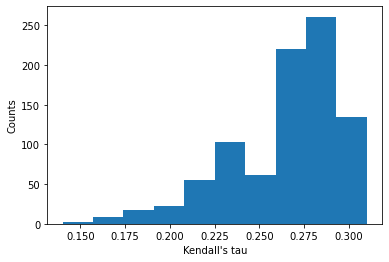

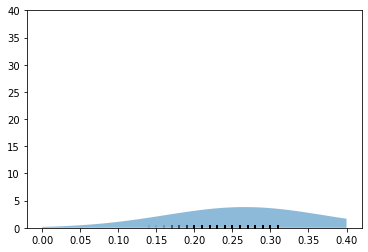

In [33]:
user_mainstreamnesses, taus_df, keep_items = compute_taus(df, minimum=600, min_implicit=0)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(0, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

#### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

In [34]:
# Remove the items that did not make the threshold
df_mpc600 = df[list(keep_items)]
print(df_mpc600)

item  1      2      3      4      5      7      14     17     20     23     \
user                                                                         
1       0.0  855.0  779.0   12.0   18.0   15.0  146.0    6.0  153.0    4.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3       2.0    0.0    2.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
4       0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
5     119.0    0.0    5.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
880     0.0    0.0   34.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
881     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
882     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    7.0   
883     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
884     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

In [79]:
tau_cutoff = X
prep = 'playcounts_mpc600'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm_items_removed"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm_items_removed"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, df_mimpl60, tau_cutoff)

309
575


KeyboardInterrupt: 

## Look into data characteristics when removing items with < 1000 playCounts

In [ ]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=1000, min_implicit=0)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(0, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

In [ ]:
tau_cutoff = X
prep = 'playcounts_l1000'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

## Look into data characteristics when removing items with < 60 user-listeners

Length of ranks_GIR_items: 2180
ranks_GIR: {71: 107532.0, 545: 93785.0, 1473: 81296.0, 563: 59664.0, 3078: 56367.0, 1510: 55218.0, 118: 53406.0, 574: 51830.0, 751: 49845.0, 2543: 48986.0, 1618: 46969.0, 1226: 45891.0, 712: 44921.0, 795: 44611.0, 1495: 44283.0, 429: 43197.0, 777: 42674.0, 3316: 42074.0, 870: 41301.0, 895: 40755.0, 746: 38266.0, 762: 37360.0, 49: 37295.0, 1198: 37187.0, 884: 37060.0, 457: 36539.0, 1390: 36279.0, 236: 36111.0, 1217: 34940.0, 731: 34802.0, 1668: 33796.0, 1004: 32633.0, 1224: 32202.0, 925: 32136.0, 1349: 32096.0, 1660: 31959.0, 761: 31567.0, 1879: 31439.0, 1703: 30932.0, 920: 30737.0, 2655: 30673.0, 782: 30584.0, 583: 30469.0, 600: 29918.0, 591: 29877.0, 1318: 29629.0, 2458: 29567.0, 1279: 29517.0, 546: 29232.0, 760: 29038.0, 1308: 28230.0, 540: 28064.0, 739: 28005.0, 1802: 27923.0, 4443: 27599.0, 794: 27347.0, 1532: 27008.0, 679: 25815.0, 1634: 25662.0, 595: 25656.0, 542: 25493.0, 84: 25318.0, 891: 25036.0, 565: 24894.0, 1147: 24703.0, 2272: 24510.0, 1850:

Finished computing users' mainstreaminesses


<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-10-17e38edbc6b8>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

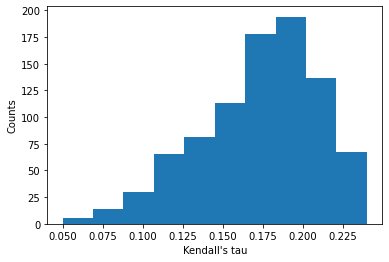

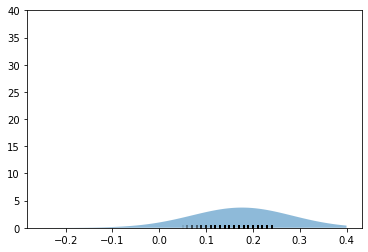

In [10]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, min_implicit=60)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

433
451


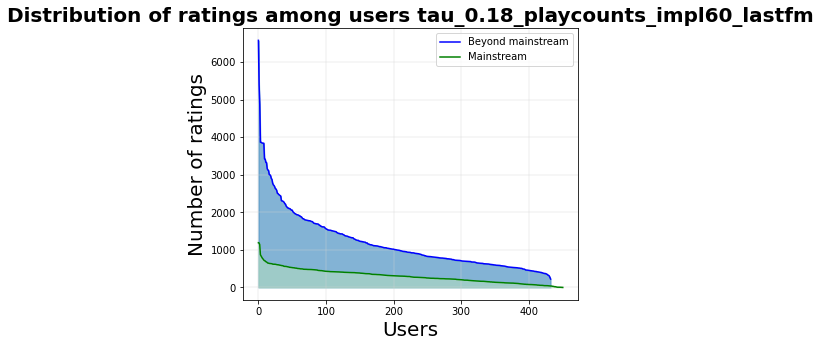

  Characteristic  Beyond-mainstream   Mainstream
0  Min. #Ratings         224.000000     1.000000
1  Max. #Ratings        6579.000000  1191.000000
2  Mean #Ratings        1199.311778   302.940133
3        # Users         433.000000   451.000000


In [11]:
tau_cutoff = 0.18
prep = 'playcounts_impl60'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, tau_cutoff)

Length of ranks_GIR_items: 2180
item  1      2      3      4      5      6      14     30     32     34     \
user                                                                         
1       0.0  855.0  779.0   12.0   18.0    8.0  146.0  268.0  100.0   87.0   
2       0.0    0.0    0.0    0.0    0.0    0.0    0.0    4.0    0.0   12.0   
3       2.0    0.0    2.0    1.0    0.0    0.0    0.0   26.0    0.0    0.0   
4       0.0    0.0    0.0    1.0    0.0    0.0    0.0   10.0    0.0   43.0   
5     119.0    0.0    5.0    1.0    0.0    2.0    0.0  336.0    0.0    0.0   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
880     0.0    0.0   34.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
881     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
882     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   11.0   
883     0.0    0.0    0.0    0.0    0.0    0.0    0.0   67.0    0.0    0.0   
884     0.0    0.0    0.0    0.0

<ipython-input-6-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-41-998eb61db825>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

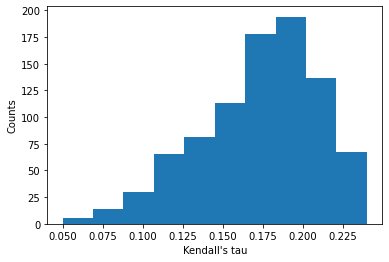

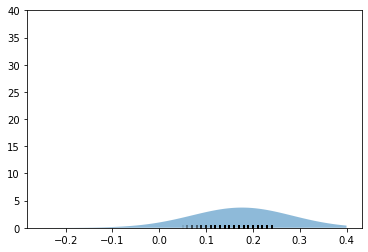

In [41]:
user_mainstreamnesses, taus_df, keep_items = compute_taus(df, minimum=0, min_implicit=60)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

In [53]:
# Remove the items that did not make the threshold
df_mimpl60 = df[list(keep_items)]
#dense_df_mimpl60 = transform_sparse_to_dense_data(df_mimpl60)
print(dense_df_mimpl60)
dense_df_mimpl60.to_csv(f'orig_dense_combined_{csv_saving_filename}.csv')

        user   item rating
0          1      2    855
1          1      3    779
2          1      4     12
3          1      5     18
4          1      6      8
...      ...    ...    ...
295929   884  10212      1
295930   884  10224     39
295931   884  10306      2
295932   884  10311      2
295933   884  17324      4

[295934 rows x 3 columns]


433
451


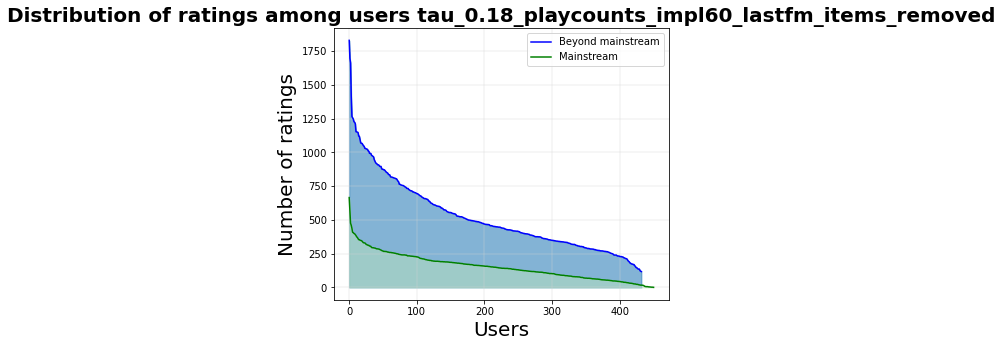

  Characteristic  Beyond-mainstream   Mainstream
0  Min. #Ratings         224.000000     1.000000
1  Max. #Ratings        6579.000000  1191.000000
2  Mean #Ratings        1199.311778   302.940133
3        # Users         433.000000   451.000000


In [44]:
tau_cutoff = 0.18
prep = 'playcounts_impl60'#preprocessing: nothing removed

plot_saving_filename = f"plot_user_distribution_tau_{tau_cutoff}_{prep}_lastfm_items_removed"
csv_saving_filename = f"tau_{tau_cutoff}_{prep}_lastfm_items_removed"

compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, csv_saving_filename, df_mimpl60, tau_cutoff)